Test of the RedPitaya with QCodes drivers

In [1]:
import sys, os
import time
import numpy as np
from scipy.signal import periodogram, welch

In [2]:
# redpitaya drivers
sys.path.append(r'C:\Users\nicol\Open Haloscope')
from red.redpitaya_qcodes import Redpitaya

<h4>Test of the drivers</h4>

In [3]:
red = Redpitaya('redpitaya', address='TCPIP::192.168.1.30::5000::SOCKET')

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.36s


In [4]:
red.OUT1_amplitude(0.2)
red.OUT1_frequency(1e6)
red.OUT1_status('ON')

red.OUT2_amplitude(0.1)
red.OUT2_frequency(2e6)
red.OUT2_status('ON')

In [5]:
red.ADC_trigger_level(0)
red.align_channels_phase()
red.trigger_channels()

red.ADC_reset()
red.ADC_start()
time.sleep(1e-6)
red.ADC_stop()

In [6]:
data_string_1 = np.array( red.IN1_read_buffer()[1:-1].split(',') )
data_1 = data_string_1.astype(float)

data_string_2 = np.array( red.IN2_read_buffer()[1:-1].split(',') )
data_2 = data_string_2.astype(float)

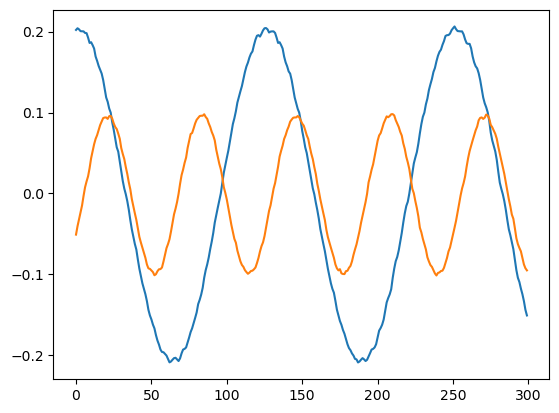

In [7]:
import matplotlib.pyplot as plt
plt.plot( data_1[0:300] )
plt.plot( data_2[0:300] )

In [8]:
red.ADC_decimation(8)

In [9]:
data = np.array( red.IN1_waveform() )

15625


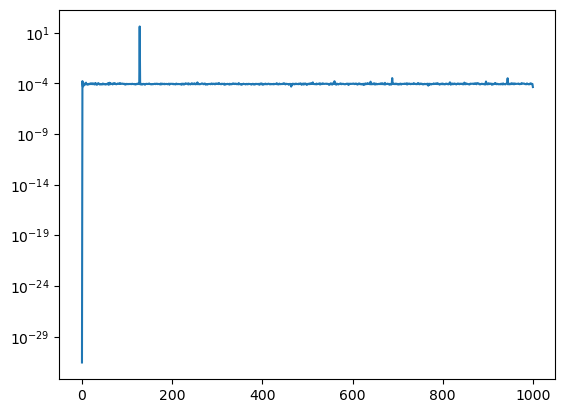

In [32]:
plt.semilogy( periodogram(data[0:2000])[1] )
#plt.xlim([950,1050])
#plt.ylim([1e-4,1000])